In [1]:
"""

這份檔案要用來執行特徵工程部分，主要利用pandas來進行處理


input：四份資料夾內文件，training、public、public_processed、private_1_processed

output：特徵處理完的training dataset(processed_data.parquet)、validation dataset(val_data.parquet)


"""

'\n\n這份檔案要用來執行特徵工程部分，主要利用pandas來進行處理\n\n\ninput：四份資料夾內文件，training、public、public_processed、private_1_processed\n\noutput：特徵處理完的training dataset(processed_data.parquet)、validation dataset(val_data.parquet)\n\n\n'

In [39]:
import pandas as pd
import numpy as np
import datetime
import dask.dataframe as dd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter
from catboost import CatBoostClassifier, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from scipy.stats import entropy


# 特徵處理

In [6]:
# 載入資料 
old_train = pd.read_csv('dataset_1st/training.csv')
new_train = pd.read_csv('dataset_2nd/public.csv')
second_train = pd.read_csv('dataset_2nd/private_1.csv')

new_val = pd.read_csv('dataset_2nd/private_1_processed.csv')
second_val = pd.read_csv('dataset_2nd/private_2_processed.csv')

example = pd.read_csv('dataset_2nd/private_2_template_v2.csv')



In [37]:
example

,txkey,pred
0,2dc3cfff76e54b508aec3a1ab7d3f3b9770d670c9cb988...,0
1,5e4e0386a88cdf7847631e80fb129bbbf942a8ab68390b...,0
2,ba2ec4f84fa996e4dbcb42984451b217fe2e9cd0b7d3da...,0
3,a6f137a7444829310471ff9dd051addc349920ae07c5bb...,0
4,b4b3f47913e3142ca7cc54ab5d98fafc00174ad1c63206...,0
...,...,...
805716,f192c75180efd46e8746c9926d48f89b4f9bd730974d67...,0
805717,79a032788e6f1c684a8c1ac514f8bd3c9fc99498698604...,0
805718,03bd77b8d2e0fa4a2d5d6fa417afb3f94ba65e4d3075ff...,0
805719,ddea7082b8a1830efa2f80b36e02378475ad89b7b2fa74...,0


In [10]:
df = pd.concat([old_train, new_train, second_train, second_val],sort=False)
df_copy = df.copy()

In [11]:
df_copy = df.copy()
df_copy

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,stocn,scity,stscd,ovrlt,flbmk,hcefg,csmcu,csmam,flg_3dsmk,label
0,1c09727c939eb69ead2a4ce4072b8aa18992a64f01fcb4...,46,101812,84d2dc85d4da6a7fa284a11a4290d7e9a969163dcb4d82...,3dd5bf1e29e5e0baa789ce692fe5dbd34ff05173acf351...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,375.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,1529,0,0.0
1,2043f245a93bc6328dac964d6dbc89f13a0346062c194d...,17,85509,9a8cf5d0afd729cb7876f6b3172152c7c9c6fabd40515c...,8cb13f9b38c7bbc02d210e580dcbbcbb6c95bf18bc3320...,5,8.0,4356c6642ef6e837543b577c7ee3ffa92b4b8fcfb57254...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,282.0,...,0.0,15759.0,NaN,0,0,8.0,70.0,101,0,0.0
2,e4853710290a8409279f3279f8032ae670824bd19aa173...,44,212641,dcc1389a5765d6f53152cf85970fbe78a83fd3d1c299b0...,1ec32868e5e1d5ff8df56737c2a91326cbfe3364382de6...,5,4.0,5b7eff061f8896aac4339ea35c25f8bb956a43bc486460...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,288.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,116,0,0.0
3,74d811b1dbc28b22b73ba2c79bb6033791d913b6d27a25...,42,102702,577f2329d1eccd59ba0abaf6113bb78dcd575badcbc57f...,4359dca1ac6a835eceb2bc0dd6b0b710f030c3499126e9...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,36684976be1f529e6e2a32c9edab4cf8e364b2b916ae2c...,375.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,1683,0,0.0
4,68ca182343969d429d79a34e532bc1ca7a3cc032c2ad81...,31,185737,fff6b4126c40620b1fbb11d4de02cd67b9e95071caa40b...,a3837f2905383f235a72679482c5f02e40f2a8ca29750d...,5,5.0,50d5b02ce3fc88723438c2a29cfdb04be4a1a11280ddb6...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,406.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,14,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805716,f192c75180efd46e8746c9926d48f89b4f9bd730974d67...,65,153455,b64dbeef5ec0b990d55769801f5b67f7a7ca6f7175a808...,f919d2ee7ec0f2bc088fb61595772bf86a3afb400432e7...,5,4.0,fb59a6c4236b61de59b7b456c9e4d3510f5b3215290288...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,282.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,188,0,NaN
805717,79a032788e6f1c684a8c1ac514f8bd3c9fc99498698604...,65,225434,98ff72c6c41f764b8bdc4326609c1d3bb77d8f837a09f3...,ba5816da2a9e896079d0204ed010b8145fd6e50ba4eeaa...,5,8.0,6b7635b3c834659abdac7dcff723f0043e6a0e205e9cb2...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,276.0,...,0.0,15808.0,NaN,0,0,1.0,70.0,1038,0,NaN
805718,03bd77b8d2e0fa4a2d5d6fa417afb3f94ba65e4d3075ff...,67,100118,bba97c1f0cec74e3cc05d8d05e7ef319b59d1724249f97...,5ae1053166a91be634d99a09fc9f076d9085aac283f061...,5,8.0,489e5caa6e2b65e6cbf57159c18b10b5cfb0d8e28bb3e3...,bcf6370b700fb26d1fab05dad5de442b2bf37689cb55fd...,378.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,3,0,NaN
805719,ddea7082b8a1830efa2f80b36e02378475ad89b7b2fa74...,65,132802,a7baecc6840c7077e48681374370a4da1689edc012e9ac...,440d4d5ed70c75c1c7874ba7ea417162cd351e7137b9ed...,5,8.0,a5ec18857b0de164680a9574ee24f6705a3d7e342931f8...,70972a182dac8d19c55cdcd00355e9c7663917b4f813c8...,282.0,...,54.0,5009.0,NaN,0,0,6.0,70.0,4638,0,NaN


In [12]:
# Step 1 計算交易活動，計算特定卡在前30天消費所佔的次數比率與之後的比率，計算之間的變化率

# 計算每張卡在其持有者所有交易中的活動次數
card_activity_count = df_copy.groupby(['chid', 'cano'])['txkey'].count()
card_activity_count = card_activity_count.rename('card_transaction_count').reset_index()
df_copy = df_copy.merge(card_activity_count, on=['chid', 'cano'], how='left')

# 計算每個持卡人的總交易次數
customer_total_transactions = df_copy.groupby('chid')['txkey'].count()
customer_total_transactions = customer_total_transactions.rename('customer_total_transactions').reset_index()

# 將每個持卡人的總交易次數合併到主資料集
df_copy = df_copy.merge(customer_total_transactions, on='chid', how='left')

# 篩選前30天的交易數據
df_copy_before_30 = df_copy[df_copy['locdt'] <= 30]

# 計算前30天的交易比例
card_activity_before_30 = df_copy_before_30.groupby(['chid', 'cano'])['txkey'].count().reset_index()
total_transactions_before_30 = df_copy_before_30.groupby('chid')['txkey'].count().reset_index()
card_ratio_before_30 = card_activity_before_30.merge(total_transactions_before_30, on='chid')
card_ratio_before_30['card_transaction_ratio_before_30'] = card_ratio_before_30['txkey_x'] / card_ratio_before_30['txkey_y']

# 篩選後30天的交易數據
df_copy_after_30 = df_copy[df_copy['locdt'] > 30]

# 計算後30天的交易比例
card_activity_after_30 = df_copy_after_30.groupby(['chid', 'cano'])['txkey'].count().reset_index()
total_transactions_after_30 = df_copy_after_30.groupby('chid')['txkey'].count().reset_index()
card_ratio_after_30 = card_activity_after_30.merge(total_transactions_after_30, on='chid')
card_ratio_after_30['card_transaction_ratio_after_30'] = card_ratio_after_30['txkey_x'] / card_ratio_after_30['txkey_y']

# 計算前後30天的比例變化率
card_ratio_change = card_ratio_before_30.merge(card_ratio_after_30, on=['chid', 'cano'])
card_ratio_change['ratio_change'] = (card_ratio_change['card_transaction_ratio_after_30'] - card_ratio_change['card_transaction_ratio_before_30']) / card_ratio_change['card_transaction_ratio_before_30']

# 已經計算好的 card_ratio_before_30, card_ratio_after_30, 和 card_ratio_change

# 將重要的欄位合併到 df_copy
df_copy = df_copy.merge(card_ratio_before_30[['chid', 'cano', 'card_transaction_ratio_before_30']], on=['chid', 'cano'], how='left')
df_copy = df_copy.merge(card_ratio_after_30[['chid', 'cano', 'card_transaction_ratio_after_30']], on=['chid', 'cano'], how='left')
df_copy = df_copy.merge(card_ratio_change[['chid', 'cano', 'ratio_change']], on=['chid', 'cano'], how='left')


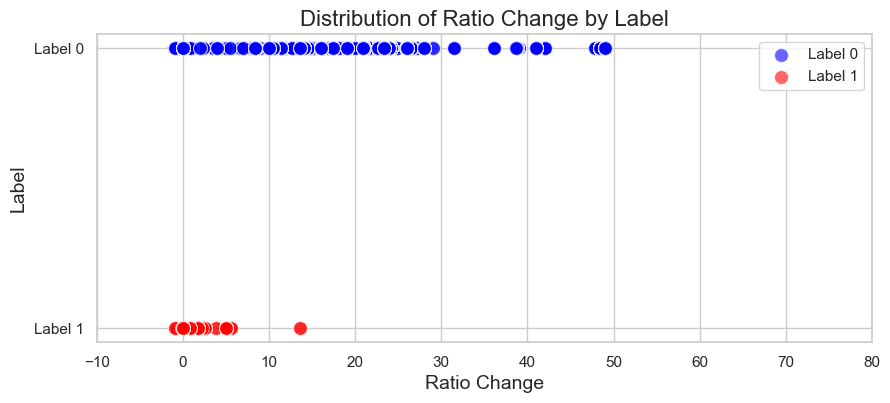

In [39]:
# 假設 df_copy 是您的 DataFrame，並且 'label' 和 'ratio_change' 是其中的列
# 此代碼塊將產生一個散點圖，橫軸是 'ratio_change'，縱軸顯示兩個不同的 'label'

# 首先過濾掉缺失值
df_filtered = df_copy.dropna(subset=['label', 'ratio_change'])

# 設定圖的大小
plt.figure(figsize=(10, 4))

# 繪製 label=0 的散點圖
sns.scatterplot(x='ratio_change', y='label', data=df_filtered[df_filtered['label'] == 0],
                color='blue', label='Label 0', s=100, alpha=0.6)

# 繪製 label=1 的散點圖，使用負數 -1 作為 y 軸值來將它們放在下方
sns.scatterplot(x='ratio_change', y=-1 * df_filtered['label'], data=df_filtered[df_filtered['label'] == 1],
                color='red', label='Label 1', s=100, alpha=0.6)

# 設置 y 軸的刻度和標籤
plt.yticks(ticks=[0, -1], labels=['Label 0', 'Label 1'])
plt.xlim(-10, 80)  # 設置 x 軸範圍為 0 到 150
# 設定標題和軸標籤
plt.title('Distribution of Ratio Change by Label', fontsize=16)
plt.xlabel('Ratio Change', fontsize=14)
plt.ylabel('Label', fontsize=14)

# 顯示圖例
plt.legend()

# 顯示圖表
plt.show()



In [13]:
# Step 2 計算每個卡號每天的交易頻率並進行正規化處理


# Step 1: 計算每個卡號的總交易次數
transaction_count_per_cano = df_copy.groupby('cano')['txkey'].count().reset_index()
transaction_count_per_cano.columns = ['cano', 'total_transactions']

# Step 2: 計算每筆交易與上一次交易的間隔天數
df_copy = df_copy.sort_values(by=['cano', 'locdt'])
df_copy['previous_transaction_date'] = df_copy.groupby('cano')['locdt'].shift(1)
df_copy['days_since_last_transaction'] = df_copy['locdt'] - df_copy['previous_transaction_date']

# Step 3: 計算每個卡號的平均使用頻率
df_copy = df_copy.merge(transaction_count_per_cano, on='cano', how='left')
df_copy['first_use_date'] = df_copy.groupby('cano')['locdt'].transform('min')
df_copy['last_use_date'] = df_copy.groupby('cano')['locdt'].transform('max')
df_copy['days_active'] = df_copy['last_use_date'] - df_copy['first_use_date'] + 1
df_copy['average_use_frequency'] = df_copy['days_active'] / df_copy['total_transactions']

# 確保數據的正確性
df_copy['days_since_last_transaction'].fillna(-1, inplace=True) 




/var/folders/8p/8bpv_8zn1kd1xx5pjcqvzc6m0000gn/T/ipykernel_42587/3123967229.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_filtered[df_filtered['label'] == 0]['average_use_frequency'], label='Label 0', shade=True)
/var/folders/8p/8bpv_8zn1kd1xx5pjcqvzc6m0000gn/T/ipykernel_42587/3123967229.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_filtered[df_filtered['label'] == 1]['average_use_frequency'], label='Label 1', shade=True)


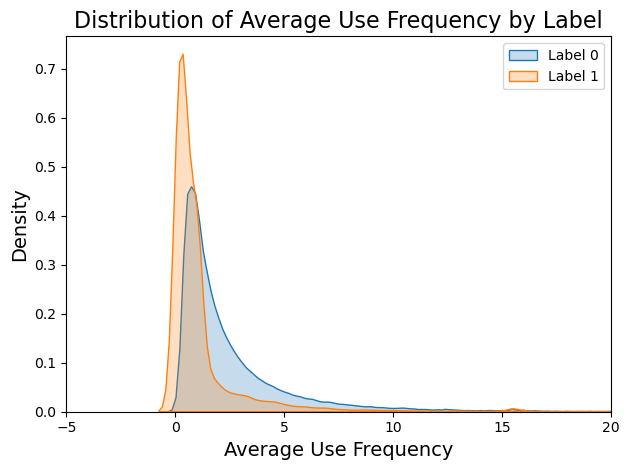

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# 首先過濾掉任何可能的NaN值
df_filtered = df_copy.dropna(subset=['average_use_frequency'])

# 繪製核密度估計圖，區分不同的label
sns.kdeplot(data=df_filtered[df_filtered['label'] == 0]['average_use_frequency'], label='Label 0', shade=True)
sns.kdeplot(data=df_filtered[df_filtered['label'] == 1]['average_use_frequency'], label='Label 1', shade=True)

# 設置圖表標題和軸標籤
plt.title('Distribution of Average Use Frequency by Label', fontsize=16)
plt.xlabel('Average Use Frequency', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim(-5, 20)  # 設置 x 軸範圍為 0 到 150

# 顯示圖例
plt.legend()

# 展示圖表
plt.tight_layout()
plt.show()


In [15]:
# Step 3 計算每個卡號的交易金額並進行正規化處理

# 定義MAD函數
def mad(series):
    return (series - series.median()).abs().median()

# Step 1: 計算每個卡號的交易金額的MAD
mad_per_cano = df_copy.groupby('cano')['conam'].apply(mad).reset_index()
mad_per_cano.columns = ['cano', 'mad_conam']

# Step 2: 將MAD值添加回原始數據框
df_copy = df_copy.merge(mad_per_cano, on='cano', how='left')

# Step 3: 計算差異
df_copy['conam_diff_from_mad'] = df_copy['conam'] - df_copy['mad_conam']


In [36]:
df_copy.groupby('label')['conam_diff_from_mad'].mean()


label
0.0    1094.407527
1.0    4413.127079
Name: conam_diff_from_mad, dtype: float64

In [16]:
# Step 4 計算上次刷卡時間(秒數)

def impute_time_zero(x):
    x = str(int(x)).zfill(6)
    return datetime.datetime.strptime(x, "%H%M%S").time()

# Apply the function to convert 'loctm' to time objects
df_copy['loctm'] = df_copy['loctm'].apply(impute_time_zero)

# Sort the DataFrame based on card number and transaction datetime
sorted_df = df_copy.sort_values(by=['cano', 'locdt', 'loctm'])

# Group by 'cano' and shift the 'locdt' and 'loctm' to get the previous transaction's date and time
sorted_df['prev_locdt'] = sorted_df.groupby('cano')['locdt'].shift(1)
sorted_df['prev_loctm'] = sorted_df.groupby('cano')['loctm'].shift(1)

# Calculate the seconds since midnight for 'loctm' and 'prev_loctm'
sorted_df['loctm_seconds'] = sorted_df['loctm'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
sorted_df['prev_loctm_seconds'] = sorted_df['prev_loctm'].apply(
    lambda x: x.hour * 3600 + x.minute * 60 + x.second if pd.notnull(x) else 0)

# Calculate the difference in days and convert to seconds, then add the difference in seconds
sorted_df['difference_seconds'] = (sorted_df['locdt'] - sorted_df['prev_locdt']) * 86400 + \
                                  (sorted_df['loctm_seconds'] - sorted_df['prev_loctm_seconds'])

# For the first transaction, we don't have a previous transaction time, so we set it to -1
sorted_df['difference_seconds'] = sorted_df['difference_seconds'].fillna(-1)

# Merge the result back into the original DataFrame
df_copy = df_copy.merge(sorted_df[['txkey', 'difference_seconds']], on='txkey', how='left')

# Display the head of the DataFrame to confirm the changes
df_copy.head()

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,previous_transaction_date,days_since_last_transaction,total_transactions,first_use_date,last_use_date,days_active,average_use_frequency,mad_conam,conam_diff_from_mad,difference_seconds
0,338c2f393db78b044726a41e033413b96a8575ad1ea067...,9,09:41:52,ae3ba1768efb2005cb0991eed4176e95d296ab00d3eb86...,000004e90549c10a46912120949a36bbe9c92fb02daa27...,5,3.0,09dd1fa2117349dc7fcbe7d88a8bbdab3eac610019010b...,2a608b081c09492bd2bc96d7def5371c4bc9cabf324a98...,486.0,...,NaN,-1.0,2,9,9,1,0.5,6715.5,-1063.5,219.0
1,f099be3150b369dc097312df37a759d6ceb332181c2a63...,9,09:38:13,ae3ba1768efb2005cb0991eed4176e95d296ab00d3eb86...,000004e90549c10a46912120949a36bbe9c92fb02daa27...,5,3.0,c8131b6b345e94a8ff34642eae76ad4c71ce2027475ebc...,2a608b081c09492bd2bc96d7def5371c4bc9cabf324a98...,486.0,...,9.0,0.0,2,9,9,1,0.5,6715.5,12367.5,-1.0
2,ca0ceb8b5efafd9af240de906a8cb0a85cc246b723f60a...,5,17:57:11,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,12c5b8c7cac508b0cf7214cee8c8ea9ebe1e23c5b0dd67...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,288.0,...,NaN,-1.0,15,5,61,57,3.8,356.0,-203.0,-1.0
3,153da2c77542c25cc788526ec3c7efaa4b7d07bb14e691...,25,20:54:59,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,57671442d26d3dd982bf9cf95274e3da8dc575d3e4ec31...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,406.0,...,5.0,20.0,15,5,61,57,3.8,356.0,-302.0,1738668.0
4,2f18af76ab1bef5b7f0cbd336be4d8ada74f8b5cf646ea...,26,21:25:44,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,07b64d578cadcf5495bcb1c0873c23c18067468f6a221c...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,272.0,...,25.0,1.0,15,5,61,57,3.8,356.0,1127.0,88245.0


/var/folders/8p/8bpv_8zn1kd1xx5pjcqvzc6m0000gn/T/ipykernel_27091/369475858.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_filtered[df_filtered['label'] == 0]['difference_seconds'], label='Label 0', shade=True)
/var/folders/8p/8bpv_8zn1kd1xx5pjcqvzc6m0000gn/T/ipykernel_27091/369475858.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_filtered[df_filtered['label'] == 1]['difference_seconds'], label='Label 1', shade=True)


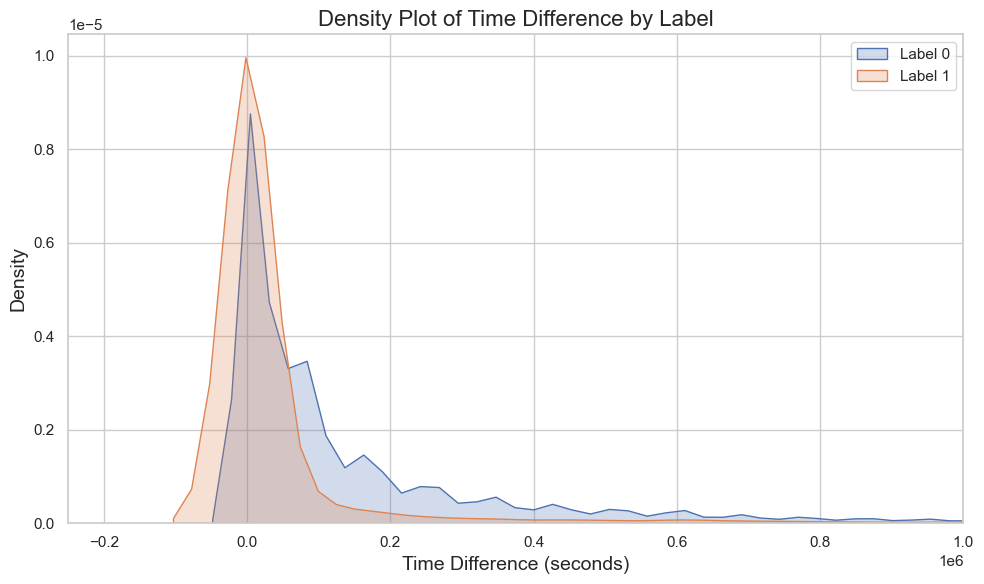

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

# 假設 df_copy 是您的 DataFrame，並且 'label' 和 'difference_seconds' 是其中的列
# 此代碼塊將產生一個密度圖，展示不同 'label' 下 'difference_seconds' 的分布

# 過濾掉任何可能的NaN值
df_filtered = df_copy.dropna(subset=['label', 'difference_seconds'])

# 設置繪圖大小
plt.figure(figsize=(10, 6))

# 繪製核密度估計圖，區分不同的label
sns.kdeplot(data=df_filtered[df_filtered['label'] == 0]['difference_seconds'], label='Label 0', shade=True)
sns.kdeplot(data=df_filtered[df_filtered['label'] == 1]['difference_seconds'], label='Label 1', shade=True)

# 設置圖表標題和軸標籤
xlim_upper = 10**6
plt.title('Density Plot of Time Difference by Label', fontsize=16)
plt.xlabel('Time Difference (seconds)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim(-0.25*xlim_upper, 1*xlim_upper) 

# 顯示圖例
plt.legend()

# 展示圖表
plt.tight_layout()
plt.show()


In [17]:
# Step 5 計算每個卡號刷卡的每筆之間的時間間隔的平均和標準差

def calculate_transaction_intervals(group):
    """
    計算信用卡交易時間間隔的平均值和標準差。

    :param group: Grouped DataFrame by 'cano'.
    :return: Tuple with average and standard deviation of transaction intervals in seconds.
    """
    # 計算日期差異（轉換為秒）和時間差異
    date_diffs = group['locdt'].diff().fillna(0) * 86400
    time_diffs = group['loctm_seconds'].diff().fillna(0)

    # 總時間差異
    total_diffs = date_diffs + time_diffs

    # 排除第一筆交易（因為它沒有前一筆交易可以比較）
    total_diffs = total_diffs[1:]

    # 計算平均值和標準差
    avg_interval = total_diffs.mean() if not total_diffs.empty else -1
    std_interval = total_diffs.std() if not total_diffs.empty else -1

    return avg_interval, std_interval

# 應用函數並創建新的 DataFrame
intervals_df = sorted_df.groupby('cano').apply(calculate_transaction_intervals)
intervals_df = pd.DataFrame(intervals_df.tolist(), index=intervals_df.index).reset_index()
intervals_df.columns = ['cano', 'avg_interval', 'std_interval']

# 合併到原始 DataFrame
df_copy = df_copy.merge(intervals_df, on='cano', how='left')

/var/folders/8p/8bpv_8zn1kd1xx5pjcqvzc6m0000gn/T/ipykernel_27091/4056382924.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_filtered_avg[df_filtered_avg['label'] == 0]['avg_interval'], label='Label 0', shade=True)
/var/folders/8p/8bpv_8zn1kd1xx5pjcqvzc6m0000gn/T/ipykernel_27091/4056382924.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_filtered_avg[df_filtered_avg['label'] == 1]['avg_interval'], label='Label 1', shade=True)
/var/folders/8p/8bpv_8zn1kd1xx5pjcqvzc6m0000gn/T/ipykernel_27091/4056382924.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_filtered_std[df_filtered_std['label']

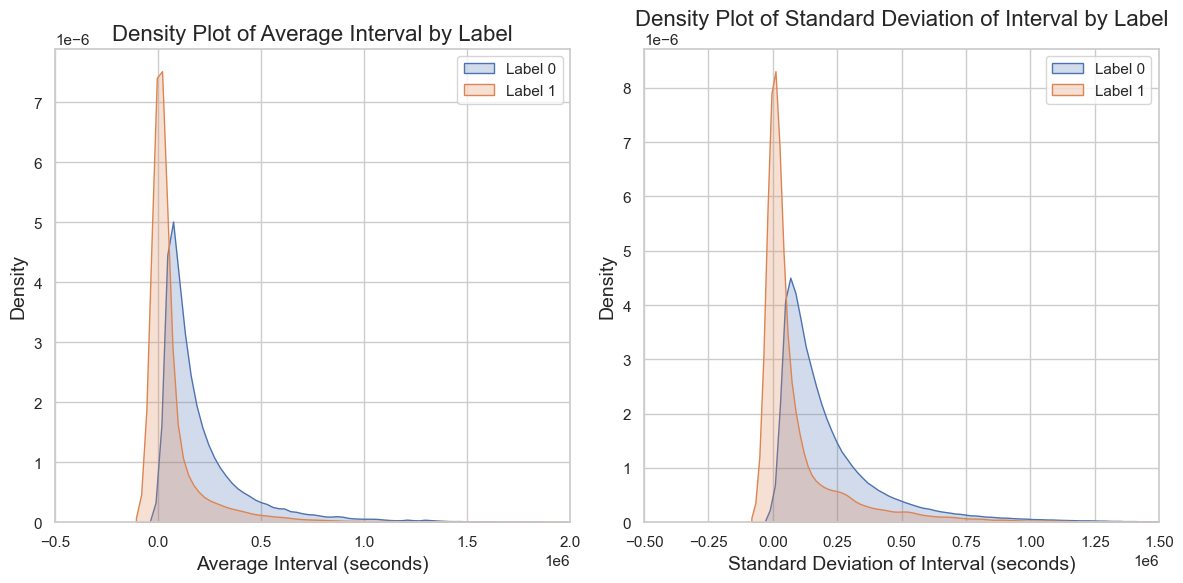

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 确保 df_copy 已经包含了 'label', 'avg_interval', 和 'std_interval' 列
# 如果 df_copy 是通过上面步骤计算得到的，则不需要再次计算

# 过滤掉任何可能的NaN值
df_filtered_avg = df_copy.dropna(subset=['label', 'avg_interval'])
df_filtered_std = df_copy.dropna(subset=['label', 'std_interval'])

# 设置图表大小
plt.figure(figsize=(12, 6))

# 绘制平均时间间隔的密度图
plt.subplot(1, 2, 1)
sns.kdeplot(data=df_filtered_avg[df_filtered_avg['label'] == 0]['avg_interval'], label='Label 0', shade=True)
sns.kdeplot(data=df_filtered_avg[df_filtered_avg['label'] == 1]['avg_interval'], label='Label 1', shade=True)
plt.title('Density Plot of Average Interval by Label', fontsize=16)
plt.xlabel('Average Interval (seconds)', fontsize=14)
plt.ylabel('Density', fontsize=14)
xlim_upper = 10**6
plt.xlim(-0.5*xlim_upper, 2*xlim_upper) 

plt.legend()

# 绘制标准差的密度图
plt.subplot(1, 2, 2)
sns.kdeplot(data=df_filtered_std[df_filtered_std['label'] == 0]['std_interval'], label='Label 0', shade=True)
sns.kdeplot(data=df_filtered_std[df_filtered_std['label'] == 1]['std_interval'], label='Label 1', shade=True)
plt.title('Density Plot of Standard Deviation of Interval by Label', fontsize=16)
plt.xlabel('Standard Deviation of Interval (seconds)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim(-0.5*xlim_upper, 1.5*xlim_upper) 

plt.legend()

# 展示图表
plt.tight_layout()
plt.show()


In [18]:
# Step 6 每張卡號在不同商品類別（mcc）下的交易情況

# 計算每個卡號在每個MCC下的交易金額差異

median_per_mcc = df_copy.groupby('mcc')['conam'].median().reset_index()
median_per_mcc.columns = ['mcc', 'median_conam_per_mcc']

df_copy = df_copy.merge(median_per_mcc, on='mcc', how='left')

df_copy['conam_diff_mcc'] = df_copy['conam'] - df_copy['median_conam_per_mcc']

# 計算每個卡號在每個MCC下的交易比例

mcc_count_per_cano = df_copy.groupby(['cano', 'mcc']).cumcount() + 1
df_copy['mcc_count_per_cano'] = mcc_count_per_cano

total_transactions_per_cano = df_copy.groupby('cano')['txkey'].transform('count')
df_copy['mcc_freq_ratio'] = df_copy['mcc_count_per_cano'] / total_transactions_per_cano



/var/folders/8p/8bpv_8zn1kd1xx5pjcqvzc6m0000gn/T/ipykernel_27091/3200889610.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_filtered[df_filtered['label'] == 0]['conam_diff_mcc'], label='Label 0', shade=True)
/var/folders/8p/8bpv_8zn1kd1xx5pjcqvzc6m0000gn/T/ipykernel_27091/3200889610.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_filtered[df_filtered['label'] == 1]['conam_diff_mcc'], label='Label 1', shade=True)
/var/folders/8p/8bpv_8zn1kd1xx5pjcqvzc6m0000gn/T/ipykernel_27091/3200889610.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_filtered[df_filtered['label'] == 0]['mcc_count_pe

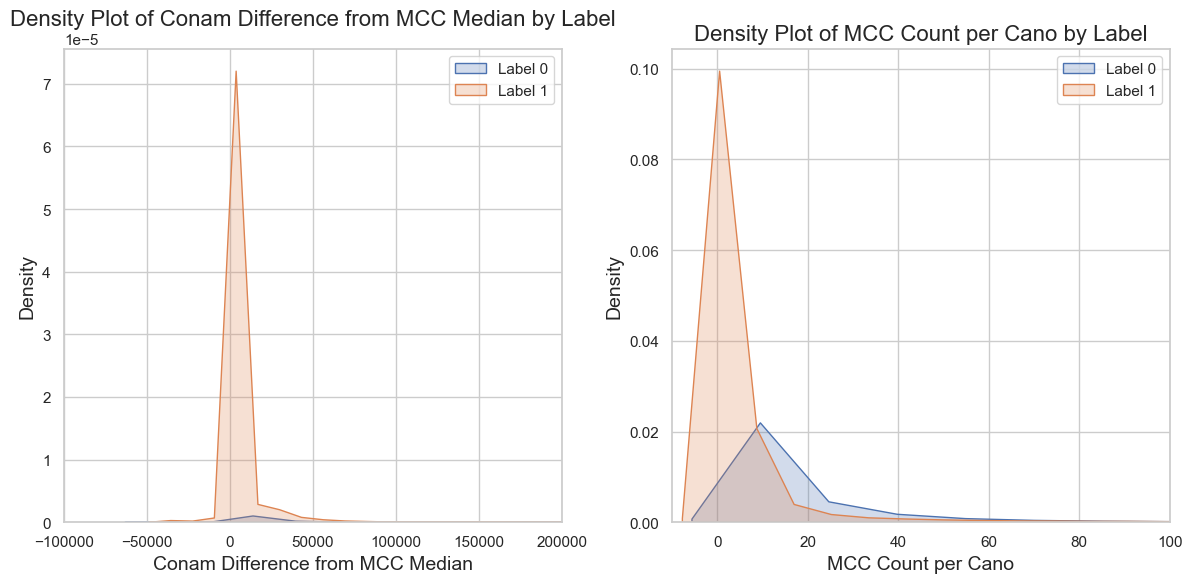

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# 确保 df_copy 已经包含了 'label', 'conam_diff_mcc', 和 'mcc_count_per_cano' 列
# 如果 df_copy 是通过上面步骤计算得到的，则不需要再次计算

# 过滤掉任何可能的NaN值
df_filtered = df_copy.dropna(subset=['label', 'conam_diff_mcc', 'mcc_count_per_cano'])

# 设置图表大小
plt.figure(figsize=(12, 6))

# 绘制 'conam_diff_mcc' 的密度图
plt.subplot(1, 2, 1)
sns.kdeplot(data=df_filtered[df_filtered['label'] == 0]['conam_diff_mcc'], label='Label 0', shade=True)
sns.kdeplot(data=df_filtered[df_filtered['label'] == 1]['conam_diff_mcc'], label='Label 1', shade=True)
plt.title('Density Plot of Conam Difference from MCC Median by Label', fontsize=16)
plt.xlabel('Conam Difference from MCC Median', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim(-0.1*xlim_upper, 0.2*xlim_upper) 

plt.legend()

# 绘制 'mcc_count_per_cano' 的密度图
plt.subplot(1, 2, 2)
sns.kdeplot(data=df_filtered[df_filtered['label'] == 0]['mcc_count_per_cano'], label='Label 0', shade=True)
sns.kdeplot(data=df_filtered[df_filtered['label'] == 1]['mcc_count_per_cano'], label='Label 1', shade=True)
plt.title('Density Plot of MCC Count per Cano by Label', fontsize=16)
plt.xlabel('MCC Count per Cano', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim(-10, 100) 

plt.legend()

# 展示图表
plt.tight_layout()
plt.show()


In [11]:
df_copy.head()

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,average_use_frequency,mad_conam,conam_diff_from_mad,difference_seconds,avg_interval,std_interval,median_conam_per_mcc,conam_diff_mcc,mcc_count_per_cano,mcc_freq_ratio
0,338c2f393db78b044726a41e033413b96a8575ad1ea067...,9,09:41:52,ae3ba1768efb2005cb0991eed4176e95d296ab00d3eb86...,000004e90549c10a46912120949a36bbe9c92fb02daa27...,5,3.0,09dd1fa2117349dc7fcbe7d88a8bbdab3eac610019010b...,2a608b081c09492bd2bc96d7def5371c4bc9cabf324a98...,486.0,...,0.5,6715.5,-1063.5,219.0,219.000000,NaN,1140.0,4512.0,1.0,0.500000
1,f099be3150b369dc097312df37a759d6ceb332181c2a63...,9,09:38:13,ae3ba1768efb2005cb0991eed4176e95d296ab00d3eb86...,000004e90549c10a46912120949a36bbe9c92fb02daa27...,5,3.0,c8131b6b345e94a8ff34642eae76ad4c71ce2027475ebc...,2a608b081c09492bd2bc96d7def5371c4bc9cabf324a98...,486.0,...,0.5,6715.5,12367.5,-1.0,219.000000,NaN,1140.0,17943.0,2.0,1.000000
2,ca0ceb8b5efafd9af240de906a8cb0a85cc246b723f60a...,5,17:57:11,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,12c5b8c7cac508b0cf7214cee8c8ea9ebe1e23c5b0dd67...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,288.0,...,3.8,356.0,-203.0,-1.0,345576.428571,469665.232949,900.0,-747.0,1.0,0.066667
3,153da2c77542c25cc788526ec3c7efaa4b7d07bb14e691...,25,20:54:59,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,57671442d26d3dd982bf9cf95274e3da8dc575d3e4ec31...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,406.0,...,3.8,356.0,-302.0,1738668.0,345576.428571,469665.232949,45.0,9.0,1.0,0.066667
4,2f18af76ab1bef5b7f0cbd336be4d8ada74f8b5cf646ea...,26,21:25:44,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,07b64d578cadcf5495bcb1c0873c23c18067468f6a221c...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,272.0,...,3.8,356.0,1127.0,88245.0,345576.428571,469665.232949,847.0,636.0,1.0,0.066667


In [19]:
# Step 7: 分析每張卡號在不同 mchno下的交易情況

# 計算每個卡號在每個 mchno下的交易金額差異

median_per_mchno = df_copy.groupby('mchno')['conam'].median().reset_index()
median_per_mchno.columns = ['mchno', 'median_conam_per_mchno']

df_copy = df_copy.merge(median_per_mchno, on='mchno', how='left')

df_copy['conam_diff_mchno'] = df_copy['conam'] - df_copy['median_conam_per_mchno']

# 計算每個卡號在每個 mchno下的交易比例

mchno_count_per_cano = df_copy.groupby(['cano', 'mchno']).cumcount() + 1
df_copy['mchno_count_per_cano'] = mcc_count_per_cano

total_transactions_per_cano = df_copy.groupby('cano')['txkey'].transform('count')
df_copy['mchno_freq_ratio'] = df_copy['mchno_count_per_cano'] / total_transactions_per_cano



In [13]:
df_copy.head()

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,avg_interval,std_interval,median_conam_per_mcc,conam_diff_mcc,mcc_count_per_cano,mcc_freq_ratio,median_conam_per_mchno,conam_diff_mchno,mchno_count_per_cano,mchno_freq_ratio
0,338c2f393db78b044726a41e033413b96a8575ad1ea067...,9,09:41:52,ae3ba1768efb2005cb0991eed4176e95d296ab00d3eb86...,000004e90549c10a46912120949a36bbe9c92fb02daa27...,5,3.0,09dd1fa2117349dc7fcbe7d88a8bbdab3eac610019010b...,2a608b081c09492bd2bc96d7def5371c4bc9cabf324a98...,486.0,...,219.000000,NaN,1140.0,4512.0,1.0,0.500000,4800.0,852.0,1.0,0.500000
1,f099be3150b369dc097312df37a759d6ceb332181c2a63...,9,09:38:13,ae3ba1768efb2005cb0991eed4176e95d296ab00d3eb86...,000004e90549c10a46912120949a36bbe9c92fb02daa27...,5,3.0,c8131b6b345e94a8ff34642eae76ad4c71ce2027475ebc...,2a608b081c09492bd2bc96d7def5371c4bc9cabf324a98...,486.0,...,219.000000,NaN,1140.0,17943.0,2.0,1.000000,19083.0,0.0,2.0,1.000000
2,ca0ceb8b5efafd9af240de906a8cb0a85cc246b723f60a...,5,17:57:11,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,12c5b8c7cac508b0cf7214cee8c8ea9ebe1e23c5b0dd67...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,288.0,...,345576.428571,469665.232949,900.0,-747.0,1.0,0.066667,197.0,-44.0,1.0,0.066667
3,153da2c77542c25cc788526ec3c7efaa4b7d07bb14e691...,25,20:54:59,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,57671442d26d3dd982bf9cf95274e3da8dc575d3e4ec31...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,406.0,...,345576.428571,469665.232949,45.0,9.0,1.0,0.066667,20.0,34.0,1.0,0.066667
4,2f18af76ab1bef5b7f0cbd336be4d8ada74f8b5cf646ea...,26,21:25:44,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,07b64d578cadcf5495bcb1c0873c23c18067468f6a221c...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,272.0,...,345576.428571,469665.232949,847.0,636.0,1.0,0.066667,308.0,1175.0,1.0,0.066667


In [20]:
# Step 8 觀察交易地點變化

# Step 1: 計算每個卡號在每個城市和國家的總交易次數
city_transaction_counts = df_copy.groupby(['cano', 'scity']).size().reset_index(name='city_count')
country_transaction_counts = df_copy.groupby(['cano', 'stocn']).size().reset_index(name='country_count')

# Step 2: 最大最小標準化
def min_max_scale(series):
    return (series - series.min()) / (series.max() - series.min()) * 100

city_transaction_counts['city_score'] = min_max_scale(city_transaction_counts['city_count'])
country_transaction_counts['country_score'] = min_max_scale(country_transaction_counts['country_count'])

# Step 3: 將轉換後的分數合併到原始數據框
df_copy = df_copy.merge(city_transaction_counts[['cano', 'scity', 'city_score']], on=['cano', 'scity'], how='left')
df_copy = df_copy.merge(country_transaction_counts[['cano', 'stocn', 'country_score']], on=['cano', 'stocn'], how='left')





/var/folders/8p/8bpv_8zn1kd1xx5pjcqvzc6m0000gn/T/ipykernel_27091/330867574.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_filtered_city[df_filtered_city['label'] == 0]['city_score'], label='Label 0', shade=True)
/var/folders/8p/8bpv_8zn1kd1xx5pjcqvzc6m0000gn/T/ipykernel_27091/330867574.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_filtered_city[df_filtered_city['label'] == 1]['city_score'], label='Label 1', shade=True)
/var/folders/8p/8bpv_8zn1kd1xx5pjcqvzc6m0000gn/T/ipykernel_27091/330867574.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_filtered_country[df_filtered_country['la

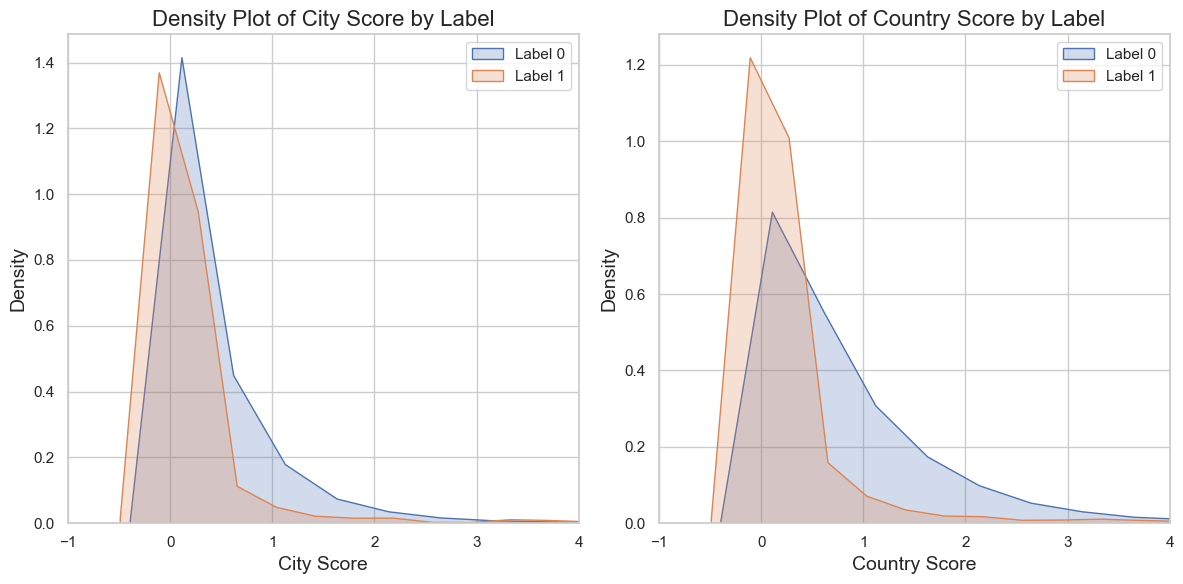

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# 过滤掉任何可能的NaN值
df_filtered_city = df_copy.dropna(subset=['label', 'city_score'])
df_filtered_country = df_copy.dropna(subset=['label', 'country_score'])

# 设置图表大小
plt.figure(figsize=(12, 6))

# 绘制 'city_score' 的密度图
plt.subplot(1, 2, 1)
sns.kdeplot(data=df_filtered_city[df_filtered_city['label'] == 0]['city_score'], label='Label 0', shade=True)
sns.kdeplot(data=df_filtered_city[df_filtered_city['label'] == 1]['city_score'], label='Label 1', shade=True)
plt.title('Density Plot of City Score by Label', fontsize=16)
plt.xlabel('City Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim(-1, 4) 

plt.legend()

# 绘制 'country_score' 的密度图
plt.subplot(1, 2, 2)
sns.kdeplot(data=df_filtered_country[df_filtered_country['label'] == 0]['country_score'], label='Label 0', shade=True)
sns.kdeplot(data=df_filtered_country[df_filtered_country['label'] == 1]['country_score'], label='Label 1', shade=True)
plt.title('Density Plot of Country Score by Label', fontsize=16)
plt.xlabel('Country Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim(-1, 4) 

plt.legend()

# 展示图表
plt.tight_layout()
plt.show()


In [15]:
df_copy.head()

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,median_conam_per_mcc,conam_diff_mcc,mcc_count_per_cano,mcc_freq_ratio,median_conam_per_mchno,conam_diff_mchno,mchno_count_per_cano,mchno_freq_ratio,city_score,country_score
0,338c2f393db78b044726a41e033413b96a8575ad1ea067...,9,09:41:52,ae3ba1768efb2005cb0991eed4176e95d296ab00d3eb86...,000004e90549c10a46912120949a36bbe9c92fb02daa27...,5,3.0,09dd1fa2117349dc7fcbe7d88a8bbdab3eac610019010b...,2a608b081c09492bd2bc96d7def5371c4bc9cabf324a98...,486.0,...,1140.0,4512.0,1.0,0.500000,4800.0,852.0,1.0,0.500000,0.018911,0.018836
1,f099be3150b369dc097312df37a759d6ceb332181c2a63...,9,09:38:13,ae3ba1768efb2005cb0991eed4176e95d296ab00d3eb86...,000004e90549c10a46912120949a36bbe9c92fb02daa27...,5,3.0,c8131b6b345e94a8ff34642eae76ad4c71ce2027475ebc...,2a608b081c09492bd2bc96d7def5371c4bc9cabf324a98...,486.0,...,1140.0,17943.0,2.0,1.000000,19083.0,0.0,2.0,1.000000,0.018911,0.018836
2,ca0ceb8b5efafd9af240de906a8cb0a85cc246b723f60a...,5,17:57:11,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,12c5b8c7cac508b0cf7214cee8c8ea9ebe1e23c5b0dd67...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,288.0,...,900.0,-747.0,1.0,0.066667,197.0,-44.0,1.0,0.066667,0.226929,0.263703
3,153da2c77542c25cc788526ec3c7efaa4b7d07bb14e691...,25,20:54:59,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,57671442d26d3dd982bf9cf95274e3da8dc575d3e4ec31...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,406.0,...,45.0,9.0,1.0,0.066667,20.0,34.0,1.0,0.066667,0.226929,0.263703
4,2f18af76ab1bef5b7f0cbd336be4d8ada74f8b5cf646ea...,26,21:25:44,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,07b64d578cadcf5495bcb1c0873c23c18067468f6a221c...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,272.0,...,847.0,636.0,1.0,0.066667,308.0,1175.0,1.0,0.066667,0.226929,0.263703


In [21]:
# Step 9 把loctom拆成鐘點 

def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

def time_to_hour(t):
    return t.hour

def time_to_string(t):
    return t.strftime("%H%M%S")

df_copy['hour'] = df_copy['loctm'].apply(time_to_hour)
df_copy['loctm_seconds'] = df_copy['loctm'].apply(time_to_seconds)
df_copy['loctm'] = df_copy['loctm'].apply(time_to_string)


In [22]:
df_copy.isna().sum()

txkey                                      0
locdt                                      0
loctm                                      0
chid                                       0
cano                                       0
contp                                      0
etymd                                 251773
mchno                                      0
acqic                                      0
mcc                                     5586
conam                                      0
ecfg                                       0
insfg                                      0
iterm                                      0
bnsfg                                      0
flam1                                      0
stocn                                    805
scity                                 332616
stscd                               10874931
ovrlt                                      0
flbmk                                      0
hcefg                                 356445
csmcu     

In [23]:
df_copy

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,mcc_count_per_cano,mcc_freq_ratio,median_conam_per_mchno,conam_diff_mchno,mchno_count_per_cano,mchno_freq_ratio,city_score,country_score,hour,loctm_seconds
0,338c2f393db78b044726a41e033413b96a8575ad1ea067...,9,094152,ae3ba1768efb2005cb0991eed4176e95d296ab00d3eb86...,000004e90549c10a46912120949a36bbe9c92fb02daa27...,5,3.0,09dd1fa2117349dc7fcbe7d88a8bbdab3eac610019010b...,2a608b081c09492bd2bc96d7def5371c4bc9cabf324a98...,486.0,...,1.0,0.500000,4800.0,852.0,1.0,0.500000,0.015751,0.015699,9,34912
1,f099be3150b369dc097312df37a759d6ceb332181c2a63...,9,093813,ae3ba1768efb2005cb0991eed4176e95d296ab00d3eb86...,000004e90549c10a46912120949a36bbe9c92fb02daa27...,5,3.0,c8131b6b345e94a8ff34642eae76ad4c71ce2027475ebc...,2a608b081c09492bd2bc96d7def5371c4bc9cabf324a98...,486.0,...,2.0,1.000000,19083.0,0.0,2.0,1.000000,0.015751,0.015699,9,34693
2,ca0ceb8b5efafd9af240de906a8cb0a85cc246b723f60a...,5,175711,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,12c5b8c7cac508b0cf7214cee8c8ea9ebe1e23c5b0dd67...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,288.0,...,1.0,0.066667,194.5,-41.5,1.0,0.066667,0.189006,0.219780,17,64631
3,153da2c77542c25cc788526ec3c7efaa4b7d07bb14e691...,25,205459,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,57671442d26d3dd982bf9cf95274e3da8dc575d3e4ec31...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,406.0,...,1.0,0.066667,20.0,34.0,1.0,0.066667,0.189006,0.219780,20,75299
4,2f18af76ab1bef5b7f0cbd336be4d8ada74f8b5cf646ea...,26,212544,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,07b64d578cadcf5495bcb1c0873c23c18067468f6a221c...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,272.0,...,1.0,0.066667,308.0,1175.0,1.0,0.066667,0.189006,0.219780,21,77144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10904046,8217dc03ea3e73ce31a5152e271938616af0d5cf040ea5...,68,205412,6edb31ec0992600b3cd082266c68b5654686a8ff2517bd...,ffff8fed185e7a8295d6081fcac3a78cdd72d08903b95c...,5,4.0,6c1fee0b78cb9da9ba0e4d3c91e75b3c195d66a974d9d6...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,276.0,...,14.0,0.538462,389.0,-49.0,14.0,0.538462,0.189006,0.392465,20,75252
10904047,55ef64d58987f6a0a138e34cef290c85d6a0d52049edb5...,22,165215,fbd6347f74892f3ff4791820f08c5ab4e65351f7920b4b...,ffffa5b23e42f7b181116352663f282cd5e2f94a0bf5b6...,5,4.0,60a54fc232711d35dd53ae3c85afd669264bb97daee8a4...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,288.0,...,1.0,0.250000,1047.5,-1032.5,1.0,0.250000,0.015751,0.047096,16,60735
10904048,5a9246de6e1b13a378cbbd00606d51ebf57b8b6b1ca2c1...,48,171238,fbd6347f74892f3ff4791820f08c5ab4e65351f7920b4b...,ffffa5b23e42f7b181116352663f282cd5e2f94a0bf5b6...,5,4.0,f9d987b3ef37721a886f720cdf4eb57dd71e9134999522...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,276.0,...,1.0,0.250000,320.0,165.0,1.0,0.250000,0.015751,0.047096,17,61958
10904049,ef4ed9c403e3224ec5c4e0611f8cb01d72b9f4dd6990d3...,49,081536,fbd6347f74892f3ff4791820f08c5ab4e65351f7920b4b...,ffffa5b23e42f7b181116352663f282cd5e2f94a0bf5b6...,5,5.0,fae3606ed36408e9a244f62e02ad16d1fab93584f24626...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,275.0,...,1.0,0.250000,2124.0,-444.0,1.0,0.250000,0.015751,0.047096,8,29736


#  合併要訓練的資料

In [24]:
train_data = pd.concat([old_train,new_train, second_train],sort=False)
new_train_data = df_copy.merge(train_data[['txkey']], on='txkey', how='inner')
new_val_data = df_copy.merge(example[['txkey']], on='txkey', how='inner')

In [25]:
new_train_data.to_parquet('processed_data.parquet')
new_val_data.to_parquet('val_data.parquet')
